# OVERVIEW

- MOTIVATION:
	- Previous investigation show that the base model and the chat model almost give similar performance in **next token prediction**
	- So it becomes interesting what is their difference?
		- -- >Investigate the difference in parameter between the base model and the  chat model
		- find out the parameters with big changes
			- can we use SAE features to understand which parameters are changed in the future?

# SET UP

In [73]:
import os
import transformer_lens
from transformer_lens import HookedTransformer
from transformer_lens import utils
from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, BitsAndBytesConfig
import accelerate
import bitsandbytes
import torch
import plotly
import plotly.express as px
import einops
import numpy as np
import psutil
import pandas as pd
import circuitsvis as cv

In [88]:
import os
import sys
import plotly.express as px
import torch as t
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
from pathlib import Path
import numpy as np
import einops
from jaxtyping import Int, Float
from typing import List, Optional, Tuple
import functools
from tqdm import tqdm
from IPython.display import display
import webbrowser
# import gdown
from transformer_lens.hook_points import HookPoint
from transformer_lens import utils, HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache
import circuitsvis as cv
from fancy_einsum import einsum # like numby for tensor
import math
import torch

In [63]:
SEED = 42
torch.set_grad_enabled(False)

In [64]:
# Key Helpers
def to_numpy(tensor):
    if isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, list):
        # if isinstance(tensor[0])
        tensor = list(map(to_numpy, tensor))
        array = np.array(tensor)
        if array.dtype != np.dtype("O"):
            return array
        else:
            return to_numpy_ragged_2d(tensor)
    elif isinstance(tensor, (torch.Tensor, torch.nn.parameter.Parameter)):
        if tensor.dtype == torch.bfloat16:
            tensor = tensor.float()
        return tensor.detach().cpu().numpy()
    elif type(tensor) in [int, float, bool, str]:
        return np.array(tensor)
    elif isinstance(tensor, pd.Series):
        return tensor.values
    else:
        raise ValueError(f"Input to to_numpy has invalid type: {type(tensor)}")

# LOAD MODEL

In [65]:

model = HookedTransformer.from_pretrained("gpt2-small")


C:\Users\buzlab\.conda\envs\llmtt\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



Loaded pretrained model gpt2-small into HookedTransformer


In [77]:
print("free(GB):", torch.cuda.mem_get_info()[0]/1000000000,
     "total(GB):", torch.cuda.mem_get_info()[1]/1000000000)

print("CPU percentage:", psutil.cpu_percent())

free(GB): 8.069840896 total(GB): 11.81089792
CPU percentage: 1.1


In [67]:
model

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-11): 12 x TransformerBlock(
      (ln1): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (h

# Mean, variance  of parapemter

In [11]:
print("free(GB):", torch.cuda.mem_get_info()[0]/1000000000,
     "total(GB):", torch.cuda.mem_get_info()[1]/1000000000)

print("CPU percentage:", psutil.cpu_percent())

free(GB): 9.284091904 total(GB): 11.81089792
CPU percentage: 0.5


In [26]:
median_param_base = []
median_param_chat = []

first_quarter_param_base = []
first_quarter_param_chat = []

last_quarter_param_base = []
last_quarter_param_chat = [] 

bins_all = []
counts_all = []
bin_num_all = []

param_layer_all = []
for (name, param) in model.named_parameters():
    
    if name.startswith(f"blocks."):
        param_name = name.split(".")[-1]
        param_block = name.split(".")[2]
        param_layer = name.split(".")[1]

        if name.startswith(f"blocks.{param_layer}.attn.W_Q"):
        # print(param_name)        param_base =  torch.flatten(model_7b.model.layers[layer].self_attn.q_proj.weight) 
                param_base = to_numpy(torch.flatten(param))
                
                # param_chat = torch.flatten(param_chat)
                    
                print(np.min(param_base))
                print(np.max(param_base))
        
                median_param_base = np.append(median_param_base,np.median(param_base))
                # median_param_chat = np.append(median_param_chat,np.median(param_chat))
            
                first_quarter_param_base = np.append(first_quarter_param_base,np.percentile(param_base,25))
                # first_quarter_param_chat = np.append(first_quarter_param_chat,np.percentile(param_chat,25))
            
                last_quarter_param_base = np.append(last_quarter_param_base,np.percentile(param_base,75))
                # last_quarter_param_chat = np.append(last_quarter_param_chat,np.percentile(param_chat,75))

                param_layer_all = np.append(param_layer_all,param_layer)

            

df = pd.DataFrame()
df["median_param_base"] = median_param_base
# df["median_param_chat"] = median_param_chat
df["first_quarter_param_base"] = first_quarter_param_base
# df["first_quarter_param_chat"] = first_quarter_param_chat
df["last_quarter_param_base"] = last_quarter_param_base
# df["last_quarter_param_chat"] = last_quarter_param_chat
df["param_layer_all"] = param_layer_all



-0.2875815
0.34846473
-0.61229205
0.7234341
-0.6583368
0.60093087
-0.48521942
0.5132729
-0.55716556
0.58612555
-0.62501323
0.7047713
-0.7932883
0.7410048
-0.821039
1.1335744
-0.9214164
1.0509944
-1.1169431
1.1510133
-1.185042
1.023251
-0.941894
0.82388544


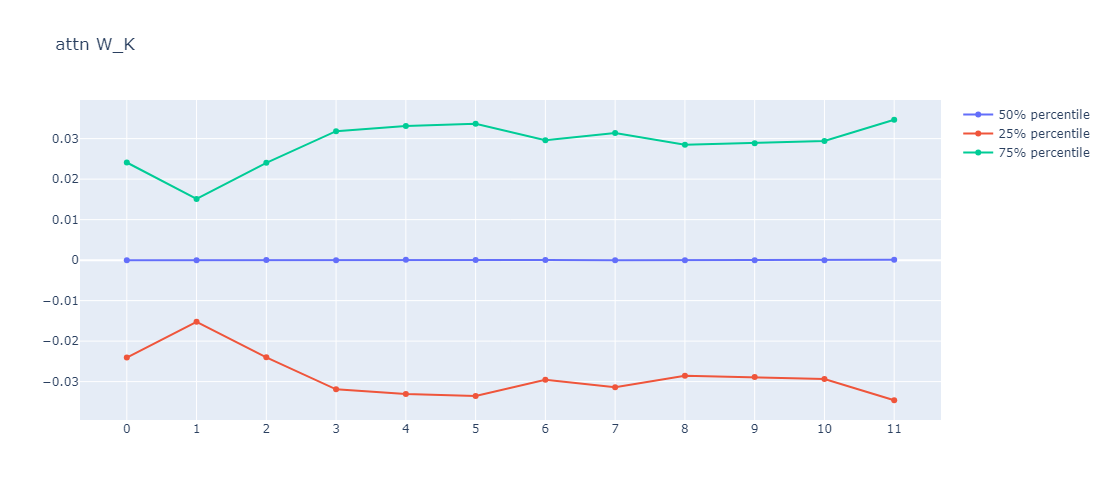

In [23]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
# for name,block in zip(param_name_unique,param_block_unique):
name = "W_K"
block = "attn"
df_plot = df

fig = make_subplots(rows = 1, cols = 1)
fig.add_trace(
    go.Scatter(
            x = df_plot["param_layer_all"].values, y = df_plot["median_param_base"].values,name = '50% percentile'),
            row=1,col=1,
            )

fig.add_trace(
    go.Scatter(
            x = df_plot["param_layer_all"].values, y = df_plot["first_quarter_param_base"].values,name = '25% percentile'),
            row=1,col=1,
            )
fig.add_trace(
    go.Scatter(
            x = df_plot["param_layer_all"].values, y = df_plot["last_quarter_param_base"].values,name = '75% percentile'),
            row=1,col=1,
            )


fig.update_layout(title_text = block +" " +name,
                 width =500, height=500)
fig.show()

In [28]:
df_plot["param_layer_all"].values

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype=object)

# Histgram

In [56]:
median_param_base = []
median_param_chat = []

first_quarter_param_base = []
first_quarter_param_chat = []

last_quarter_param_base = []
last_quarter_param_chat = [] 

bins_all = []
counts_all = []
bin_num_all = []

param_layer_all = []
for (name, param) in model.named_parameters():
    
    if name.startswith(f"blocks."):
        param_name = name.split(".")[-1]
        param_block = name.split(".")[2]
        param_layer = name.split(".")[1]

        if name.startswith(f"blocks.{param_layer}.attn.W_Q"):
        # print(param_name)        param_base =  torch.flatten(model_7b.model.layers[layer].self_attn.q_proj.weight) 
                param_base = to_numpy(torch.flatten(param))

                counts,bins = np.histogram(param_base,10)
                bins = 0.5*(bins[:-1]+ bins[1:])
                bins_all = np.append(bins_all,bins)
                counts_all = np.append(counts_all,counts)
                bin_num = np.arange(10)
                bin_num_all = np.append(bin_num_all,bin_num)
        
                for ll in np.arange(10):
                    param_layer_all = np.append(param_layer_all,param_layer)

df_hist = pd.DataFrame()

df_hist["last_quarter_param_base"] = last_quarter_param_base
# df["last_quarter_param_chat"] = last_quarter_param_chat
df_hist["param_layer_all"] = param_layer_all
df_hist["counts_all"] = counts_all
df_hist["bins_all"] = bins_all
df_hist["bin_num_all"] = bin_num_all


In [29]:
df_plot

,last_quarter_param_base,param_layer_all,counts_all,bins_all,bin_num_all
0,NaN,NaN,66.0,-0.255779,0.0
1,NaN,NaN,992.0,-0.192175,1.0
2,NaN,NaN,12083.0,-0.128570,2.0
3,NaN,NaN,98777.0,-0.064965,3.0
4,NaN,NaN,356260.0,-0.001361,4.0
...,...,...,...,...,...
115,NaN,NaN,507895.0,0.029285,5.0
116,NaN,NaN,7571.0,0.205863,6.0
117,NaN,NaN,75.0,0.382441,7.0
118,NaN,NaN,10.0,0.559019,8.0


In [46]:
to_numpy(df_plot["bins_all"].values)

array([-0.25577921, -0.19217457, -0.12856995, -0.06496532, -0.0013607 ,
        0.06224392,  0.12584855,  0.18945317,  0.25305778,  0.31666243,
       -0.54550576, -0.41193312, -0.27836052, -0.14478791, -0.01121529,
        0.12235732,  0.25592995,  0.38950256,  0.52307516,  0.6566478 ,
       -0.59537339, -0.46944666, -0.3435199 , -0.21759312, -0.09166636,
        0.03426041,  0.16018718,  0.28611395,  0.41204071,  0.5379675 ,
       -0.43529481, -0.33544558, -0.23559636, -0.13574712, -0.03589788,
        0.06395134,  0.16380058,  0.26364982,  0.36349905,  0.46334827,
       -0.50000101, -0.38567191, -0.27134278, -0.15701368, -0.04268456,
        0.07164455,  0.18597367,  0.30030277,  0.4146319 ,  0.528961  ,
       -0.55852401, -0.42554557, -0.2925671 , -0.15958866, -0.0266102 ,
        0.10636825,  0.23934671,  0.37232515,  0.50530362,  0.63828206,
       -0.7165736 , -0.56314433, -0.409715  , -0.2562857 , -0.10285639,
        0.05057292,  0.20400223,  0.35743153,  0.51086086,  0.66

In [52]:
df_hist

,last_quarter_param_base,param_layer_all,counts_all,bins_all,bin_num_all
0,NaN,NaN,66.0,-0.255779,0.0
1,NaN,NaN,992.0,-0.192175,1.0
2,NaN,NaN,12083.0,-0.128570,2.0
3,NaN,NaN,98777.0,-0.064965,3.0
4,NaN,NaN,356260.0,-0.001361,4.0
...,...,...,...,...,...
115,NaN,NaN,507895.0,0.029285,5.0
116,NaN,NaN,7571.0,0.205863,6.0
117,NaN,NaN,75.0,0.382441,7.0
118,NaN,NaN,10.0,0.559019,8.0


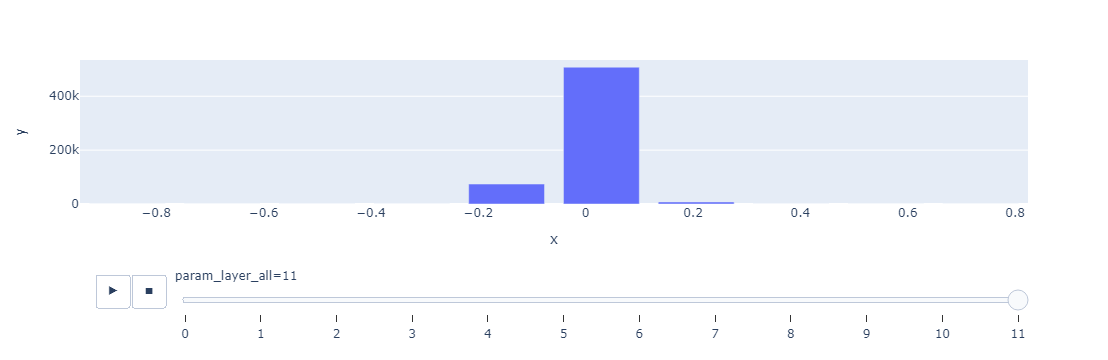

In [58]:
df_plot = df_hist
fig = px.bar(df_plot,
             x=to_numpy(df_plot['bins_all']), y=to_numpy(df_plot['counts_all']),animation_frame="param_layer_all")

fig.show()

# Visualize Attention

In [89]:
def generate_repeated_tokens(
    model: HookedTransformer, seq_len: int, batch: int = 1) -> Int[Tensor, "batch full_seq_len"]:
    '''
    Generates a sequence of repeated random tokens

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
    '''
    # self.long() is equivalent to self.to(torch.int64)
    # notice that the .long() here is necessary otherwise the
    # prefix = (t.ones(batch,1)* model.tokenizer.bos_token_id) # without .long you will get error message
    prefix = (t.ones(batch,1)* model.tokenizer.bos_token_id).long()
    seq_half = t.randint(0, model.cfg.d_vocab,(batch, seq_len),dtype=t.long) # dtype=t.int64/ default is int64 ==> but specify it for good habit
    full_sep = t.cat((prefix,seq_half,seq_half),dim=-1).to(device)
    return full_sep


def run_and_cache_model_repeated_tokens(model: HookedTransformer, seq_len: int, batch: int = 1) -> Tuple[t.Tensor, t.Tensor, ActivationCache]:
    '''
    Generates a sequence of repeated random tokens, and runs the model on it, returning logits, tokens and cache

    Should use the `generate_repeated_tokens` function above

    Outputs are:
        rep_tokens: [batch, 1+2*seq_len]
        rep_logits: [batch, 1+2*seq_len, d_vocab]
        rep_cache: The cache of the model run on rep_tokens
    '''
    rep_tokens = generate_repeated_tokens(model,seq_len,batch)
    print(rep_tokens.dtype)
    rep_logits,rep_cache = model.run_with_cache(rep_tokens)
    # rep_tokens = rep_logits.argmax(-1)
    return rep_tokens,rep_logits,rep_cache



def get_log_probs(
    logits: Float[Tensor, "batch posn d_vocab"], 
    tokens: Int[Tensor, "batch posn"]
) -> Float[Tensor, "batch posn-1"]:
    
    log_probs = logits.log_softmax(dim=-1)
    # Get logprobs the first seq_len-1 predictions (so we can compare them with the actual next tokens)
    log_probs_for_tokens = log_probs[:, :-1].gather(dim=-1, index=tokens[:, 1:].unsqueeze(-1)).squeeze(-1)

    return log_probs_for_tokens




def plot_loss_difference(log_probs, rep_str, seq_len):
    fig = px.line(
        to_numpy(log_probs), hover_name=rep_str[1:],
        title=f"Per token log prob on correct token, for sequence of length {seq_len}*2 (repeated twice)",
        labels={"index": "Sequence position", "value": "Log prob"}
    ).update_layout(showlegend=False, hovermode="x unified")
    fig.add_vrect(x0=0, x1=seq_len-.5, fillcolor="red", opacity=0.2, line_width=0)
    fig.add_vrect(x0=seq_len-.5, x1=2*seq_len-1, fillcolor="green", opacity=0.2, line_width=0)
    fig.show()

torch.int64
Performance on the first half: -13.014
Performance on the second half: -0.514


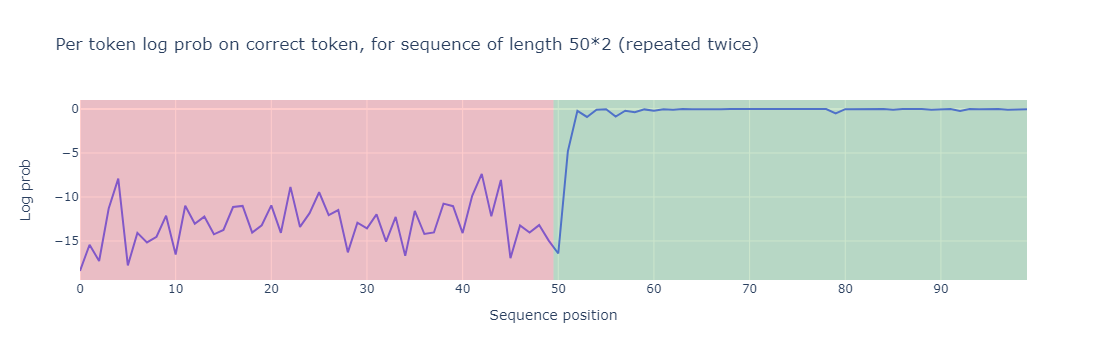

In [90]:
device = "cuda"
seq_len = 50
batch = 1
(rep_tokens, rep_logits, rep_cache) = run_and_cache_model_repeated_tokens(model, seq_len, batch)
rep_cache.remove_batch_dim()
rep_str = model.to_str_tokens(rep_tokens)
model.reset_hooks()
log_probs = get_log_probs(rep_logits, rep_tokens).squeeze()

print(f"Performance on the first half: {log_probs[:seq_len].mean():.3f}")
print(f"Performance on the second half: {log_probs[seq_len:].mean():.3f}")

plot_loss_difference(log_probs, rep_str, seq_len)

In [91]:

layer = 5
attention_pattern = rep_cache["pattern",layer]
display(cv.attention.attention_patterns(
    tokens = rep_str,
    attention = attention_pattern,
    attention_head_names=[f"L{layer}H{i}" for i in range(12)],
))